In [1]:
import sys
sys.path.append("/scratch/group/csce435-f24/python-3.10.4/lib/python3.10/site-packages")
sys.path.append("/scratch/group/csce435-f24/thicket")
from glob import glob

import matplotlib.pyplot as plt
import pandas as pd

import thicket as th

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

Read all files

In [2]:
#1_trial is a name of a folder containing the cali files, you may create a folder with a different name and replace the folder name here
tk = th.Thicket.from_caliperreader(glob("../project/caliper_output/*.cali"))
print(tk.tree(metric_column='Avg time/rank'))

(2/2) Creating Thicket: 100%|██████████| 279/279 [00:10<00:00, 27.89it/s]


  _____ _     _      _        _   
 |_   _| |__ (_) ___| | _____| |_ 
   | | | '_ \| |/ __| |/ / _ \ __|
   | | | | | | | (__|   <  __/ |_ 
   |_| |_| |_|_|\___|_|\_\___|\__|  v2024.1.0

0.024 MPI_Comm_dup
0.000 MPI_Finalize
0.000 MPI_Finalized
0.000 MPI_Initialized
0.587 main
├─ 0.051 comm
│  ├─ 0.020 comm_large
│  │  ├─ 0.008 MPI_Alltoall
│  │  └─ 0.011 MPI_Alltoallv
│  └─ 0.031 comm_small
│     └─ 0.031 MPI_Allreduce
├─ 0.410 comp
│  └─ 0.403 comp_large
├─ 0.007 correctness_check
│  ├─ 0.002 MPI_Recv
│  └─ 0.000 MPI_Send
└─ 0.011 data_init_runtime
   ├─ nan data_init_runtime
   └─ 0.011 data_perturbed_init_runtime
      └─ 0.009 data_init_runtime

Legend (Metric: Avg time/rank Min: 0.00 Max: 0.59 indices: {'profile': 18638398})
█ 0.53 - 0.59
█ 0.41 - 0.53
█ 0.29 - 0.41
█ 0.18 - 0.29
█ 0.06 - 0.18
█ 0.00 - 0.06

name User code    ◀  Only in left graph    ▶  Only in right graph



View Calltree

In [3]:
tk.metadata_column_to_perfdata("num_procs")
tk.metadata_column_to_perfdata("input_size")
tk.metadata_column_to_perfdata("input_type")
tk.dataframe = tk.dataframe.reset_index().set_index(["node", "num_procs", "input_size", "input_type"]).sort_index()
tk.show_metric_columns()

df = tk.dataframe.reset_index()
df['input_size'] = df.apply(lambda row: row['input_size'] * row['num_procs'], axis=1)

# Define common variables
processes = [2, 4, 8, 16, 32, 64, 128, 256, 1024]
threads =  [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
input_sizes = [16, 18, 20, 22, 24, 26, 28]
input_types = ["Sorted", "1_perc_perturbed", "Random", "ReverseSorted"]

# Change font size for all plots
plt.rcParams.update({"font.size": 20})

In [4]:
def plot_mpl(df, title, xlabel, ylabel):
    fig = plt.figure(figsize=(15,7))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(
        df,
        marker='o',
        linestyle="--"
    )
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(["2^16", "2^18", "2^20", "2^22", "2^24", "2^26", "2^28"])
    plt.xscale("log", base=2)
    plt.xticks(threads)
    ax.set_xticklabels(threads)
    ax.set_ylim(bottom=0, top=None)
    plt.show()
    return fig, ax

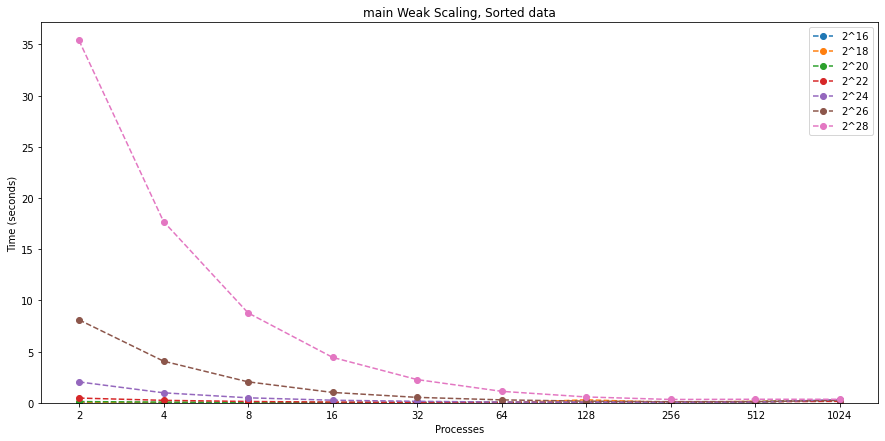

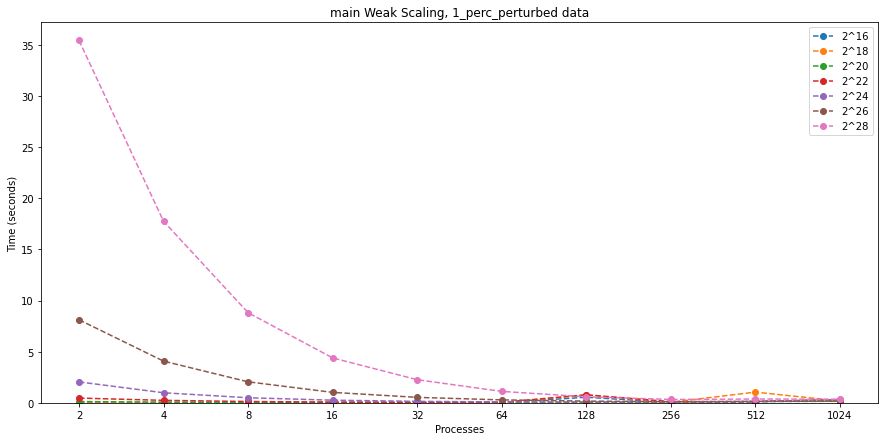

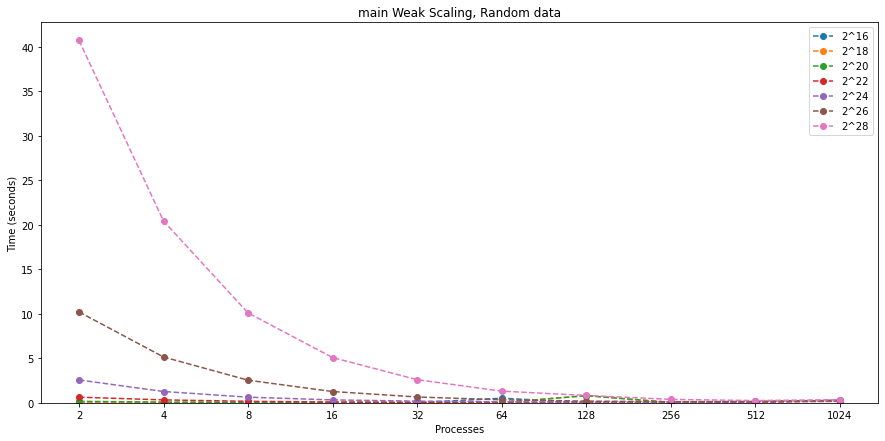

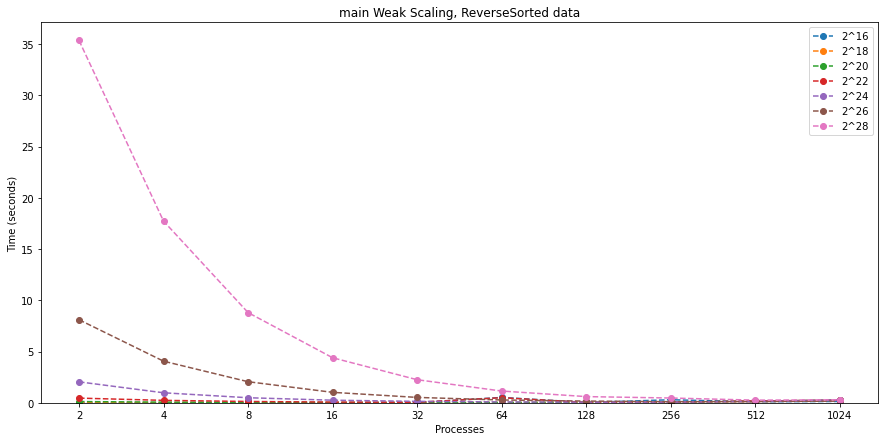

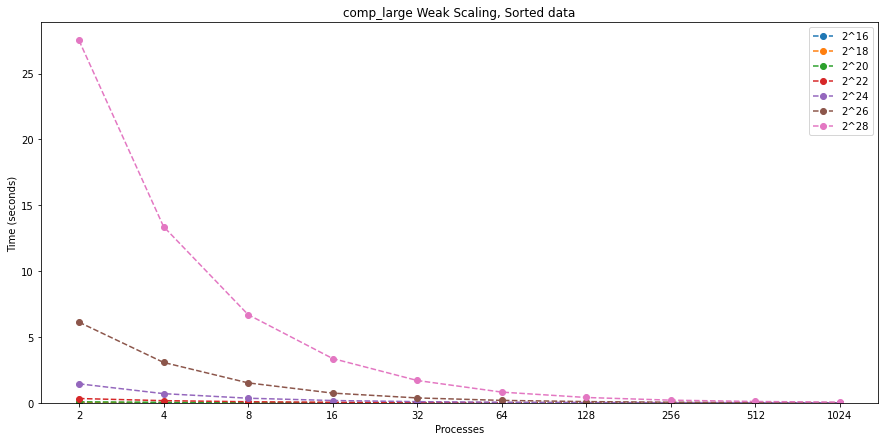

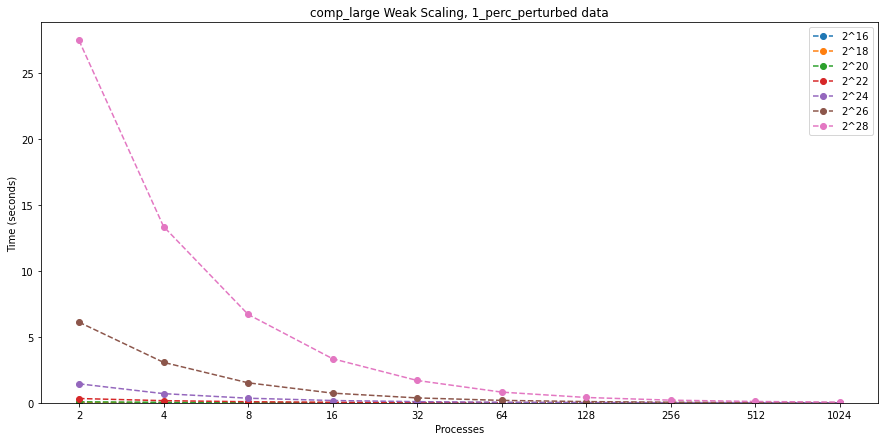

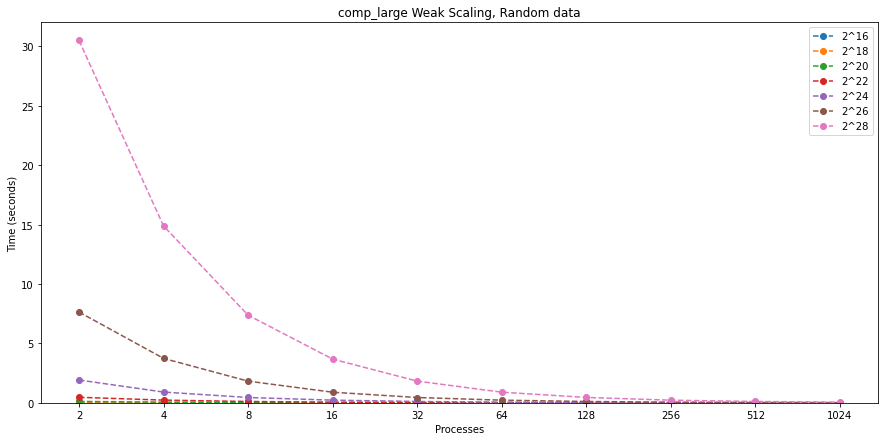

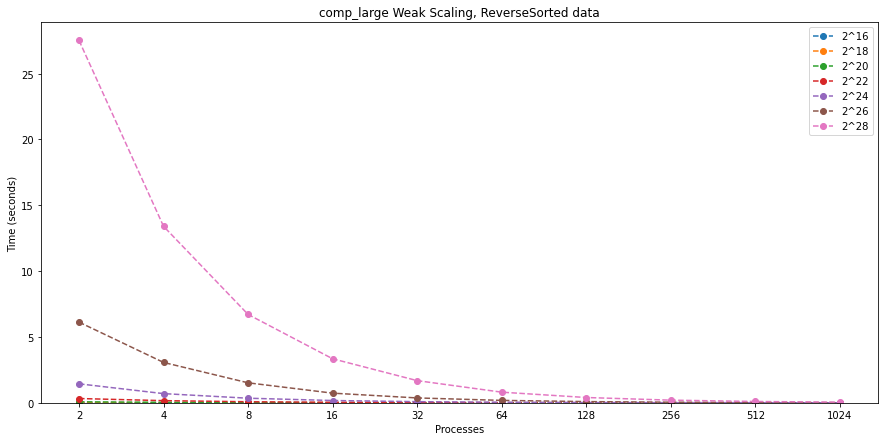

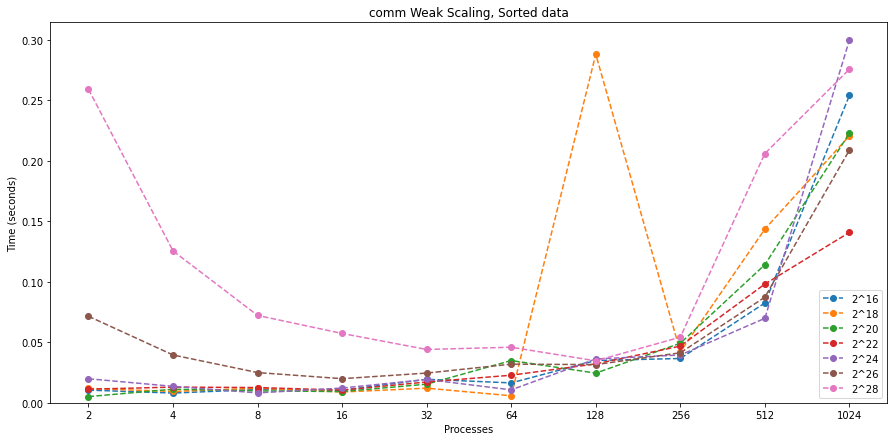

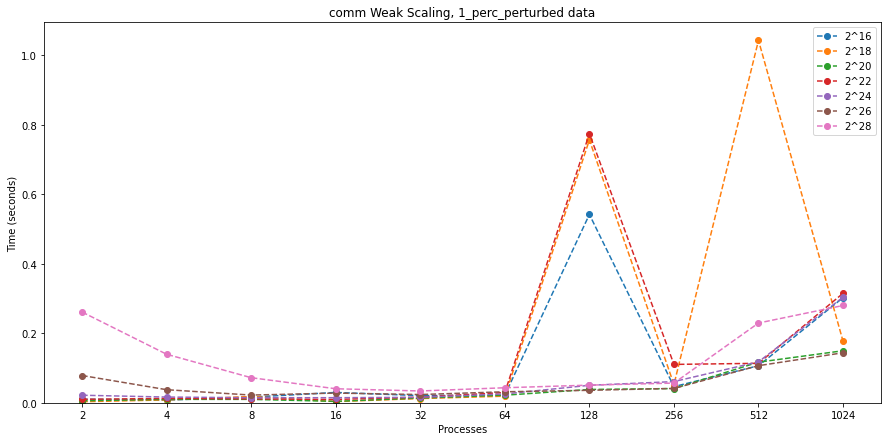

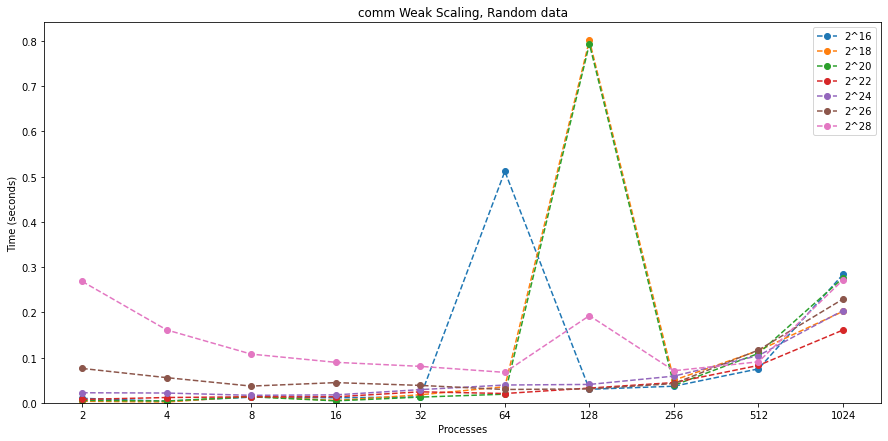

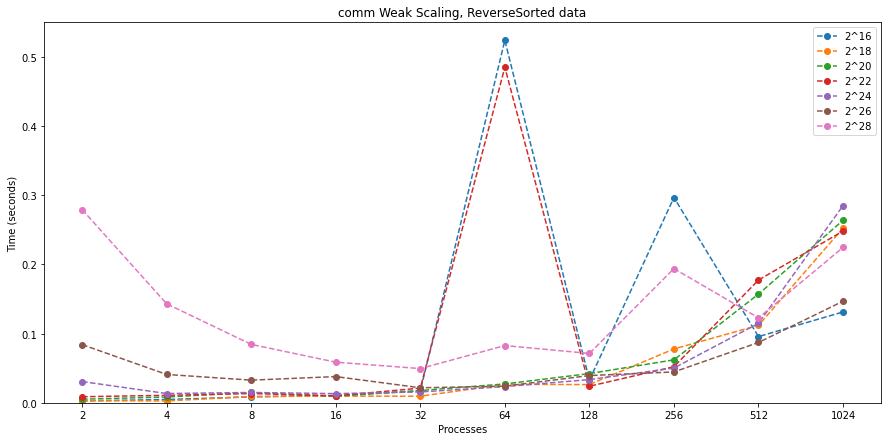

In [5]:
categories = ["main", "comp_large", "comm"]

for cat in categories:
    for type in input_types:
        # Use a temporary DataFrame for each iteration to avoid modifying df
        temp_df = df[(df["name"] == cat) & (df["input_type"] == type)]
        temp_df = temp_df.loc[:, ["Avg time/rank", "num_procs", "input_size", "input_type"]]

        # Pivot the table and replace NaN values
        temp_pivot = temp_df.pivot_table(index='input_size', columns='num_procs', values='Avg time/rank', aggfunc="sum")
        temp_pivot = temp_pivot.reset_index().set_index("input_size")

        # Plot the transposed DataFrame
        plot_mpl(
            temp_pivot.transpose(),
            title=f"{cat} Weak Scaling, {type} data",
            xlabel="Processes",
            ylabel="Time (seconds)",
        )

In [6]:
def plot_strong_scaling(df, cat, type):
    filtered_df = df[df["name"] == cat]
    filtered_df = filtered_df[filtered_df["input_type"] == type]
    
    # Filter for problem size 2^24
    fixed_size = 2**24
    filtered_df = filtered_df[filtered_df["input_size"] == fixed_size]
    
    filtered_df = filtered_df[["Avg time/rank", "num_procs"]]
    pivot_df = pd.pivot_table(
        data=filtered_df,
        values="Avg time/rank",
        columns="num_procs",
        aggfunc="mean"
    )
    
    # Create plot
    fig = plt.figure(figsize=(15,7))
    ax = fig.add_subplot(1, 1, 1)
    
    processor_counts = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
    
    ax.plot(
        pivot_df.columns,  
        pivot_df.iloc[0],  # y-axis: execution time
        marker='o',
    )
    
    ax.set_title(f"Strong Scaling - {cat}, {type} data (N=2^24)")
    ax.set_xlabel("Number of Processors")
    ax.set_ylabel("Time (seconds)")
    plt.xscale("log", base=2)
    plt.xticks(processor_counts)
    ax.set_xticklabels(processor_counts)  
    ax.set_ylim(bottom=0)
    plt.grid(False)
    plt.show()
    
    return pivot_df

In [7]:
def plot_speedup(df, cat, type):
    """
    Create speedup plot (T1/Tn)
    Fixed problem size (2^24), plot speedup vs number of processors
    """
    # Filter data for the specific category and type
    filtered_df = df[df["name"] == cat]
    filtered_df = filtered_df[filtered_df["input_type"] == type]
    
    # Filter for problem size 2^24
    fixed_size = 2**24
    filtered_df = filtered_df[filtered_df["input_size"] == fixed_size]
    
    # Select needed columns and create pivot table
    filtered_df = filtered_df[["Avg time/rank", "num_procs"]]
    pivot_df = pd.pivot_table(
        data=filtered_df,
        values="Avg time/rank",
        columns="num_procs",
        aggfunc="mean"
    )
    
    # Calculate speedup (T1/Tn)
    T1 = pivot_df.iloc[0][pivot_df.columns[0]]  # Time with minimum processors
    speedup = T1 / pivot_df.iloc[0]
    
    # Create plot
    fig = plt.figure(figsize=(15,7))
    ax = fig.add_subplot(1, 1, 1)
    
    processor_counts = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
    
    # Plot actual speedup
    ax.plot(
        speedup.index,  # x-axis: number of processors
        speedup,        # y-axis: speedup
        marker='o',
        label='Actual Speedup'
    )
    
    ax.set_title(f"Speedup - {cat}, {type} data (N=2^24)")
    ax.set_xlabel("Number of Processors")
    ax.set_ylabel("Speedup (T1/Tn)")
    plt.xscale("log", base=2)
    plt.yscale("log", base=2)
    plt.xticks(processor_counts)
    plt.yticks(processor_counts)
    ax.set_xticklabels(processor_counts)  # Use actual numbers
    ax.set_yticklabels(processor_counts)  # Use actual numbers
    ax.legend()
    plt.grid(False)
    plt.show()
    
    return speedup

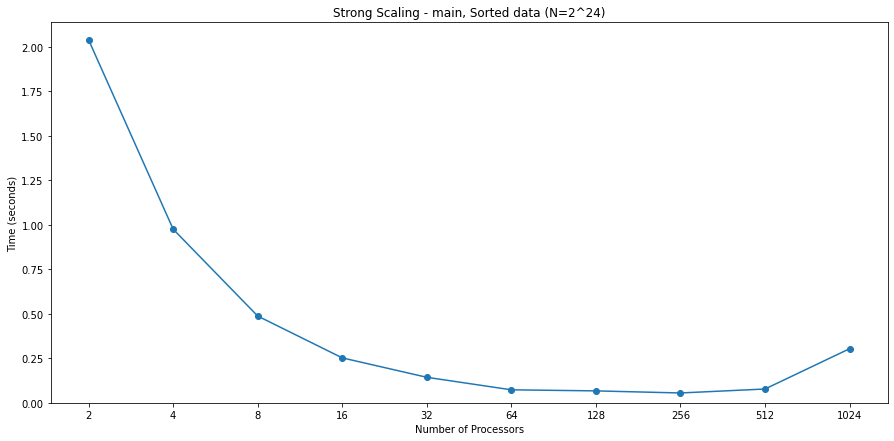

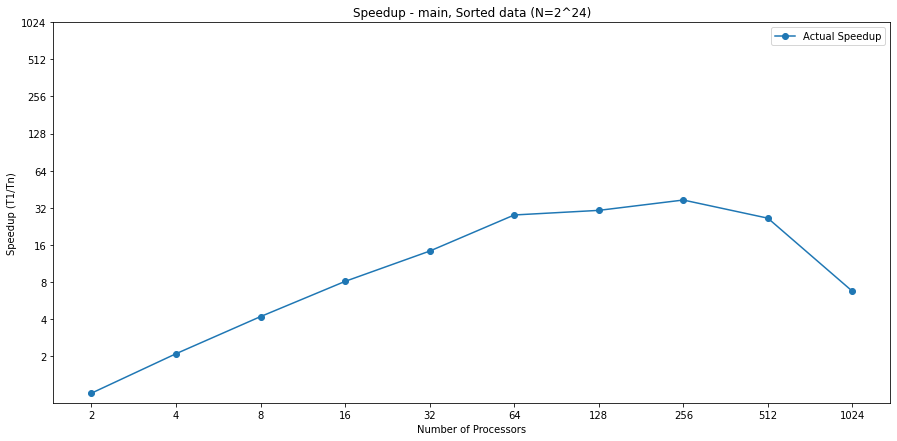

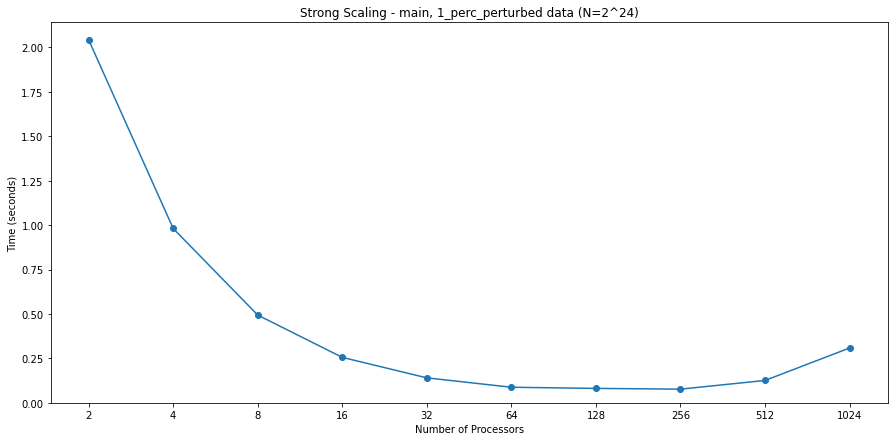

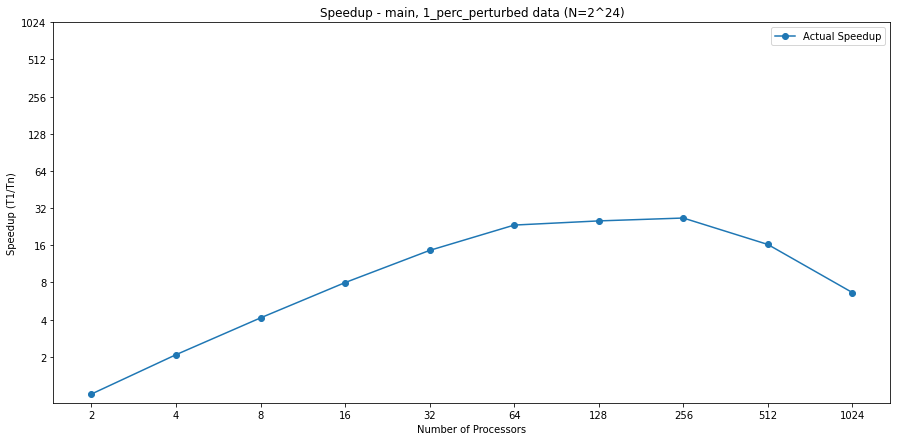

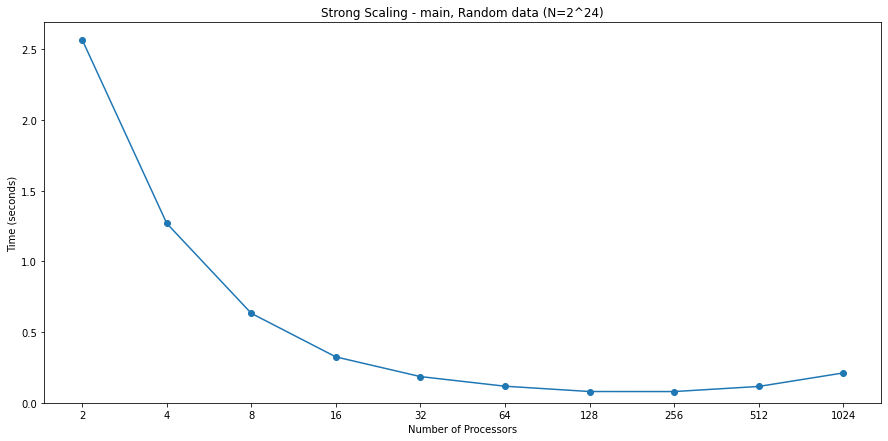

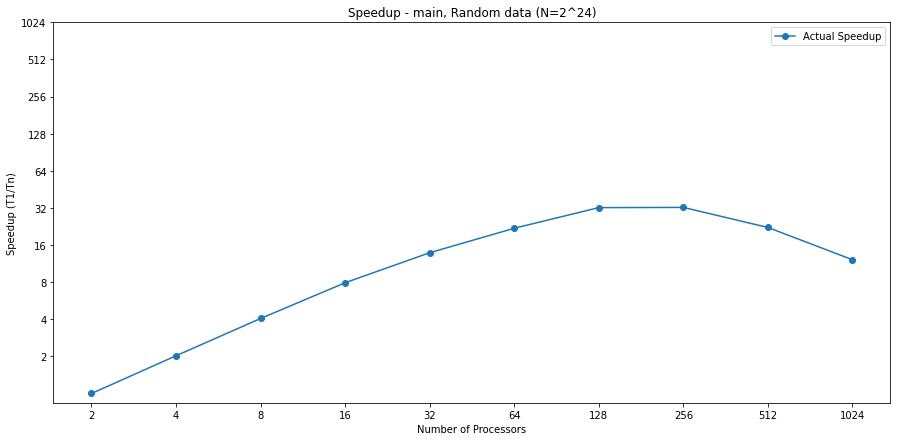

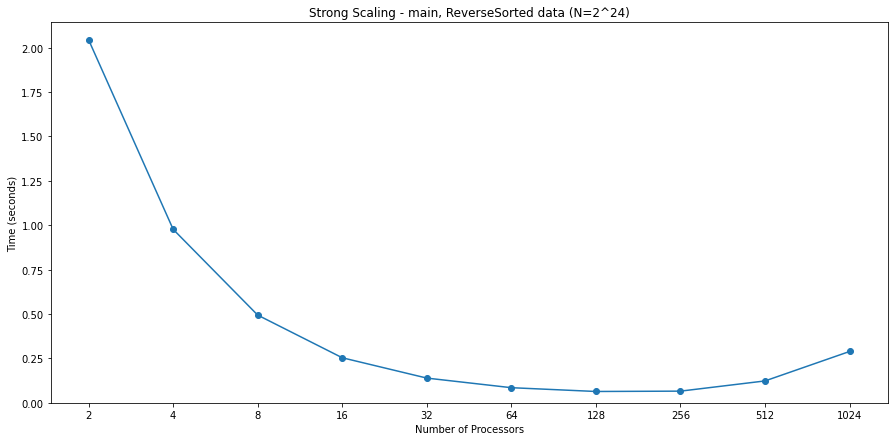

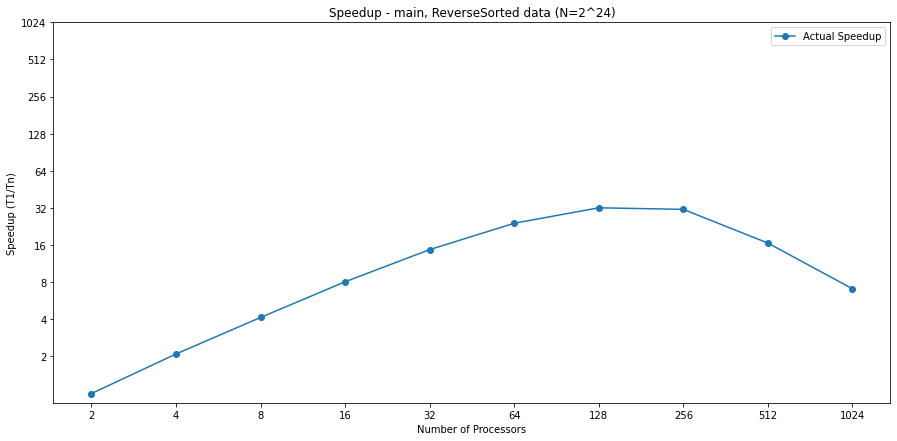

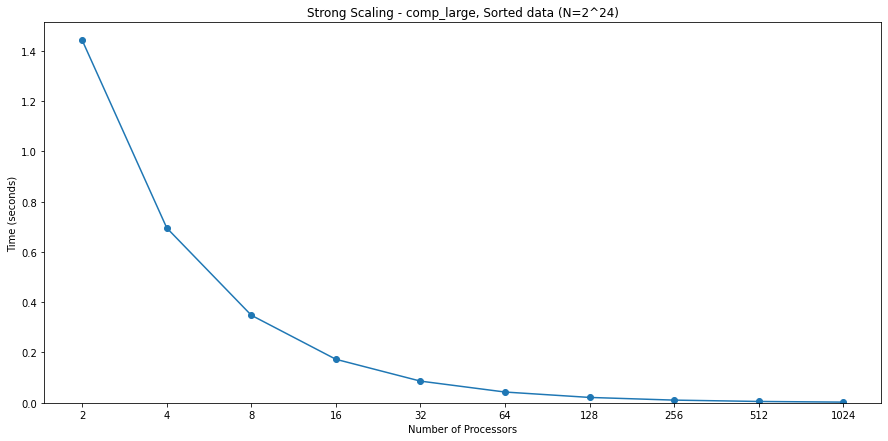

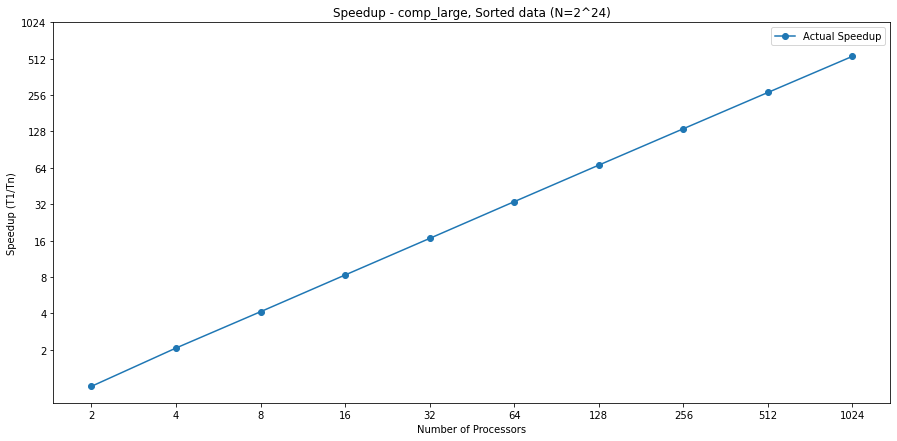

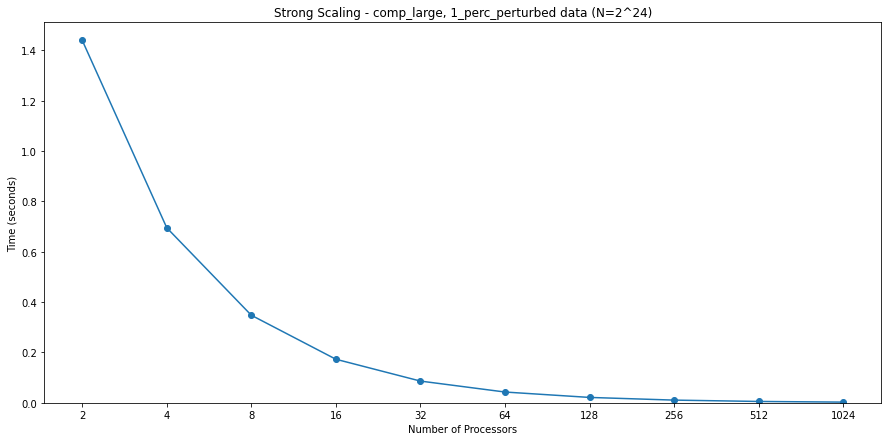

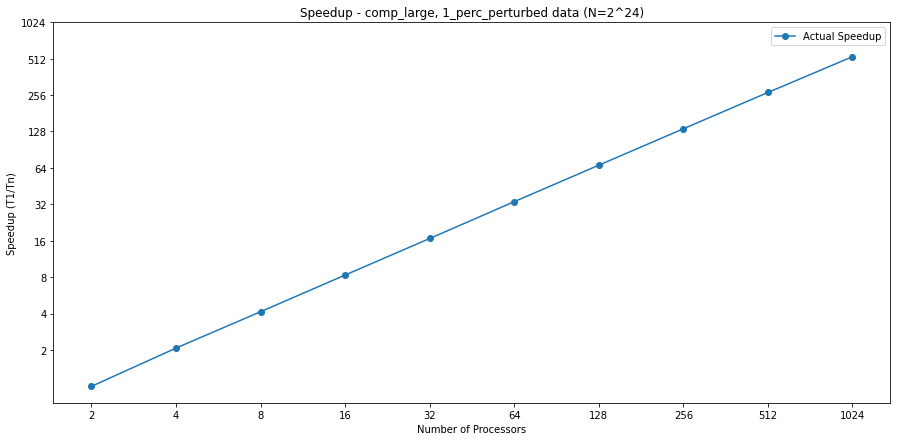

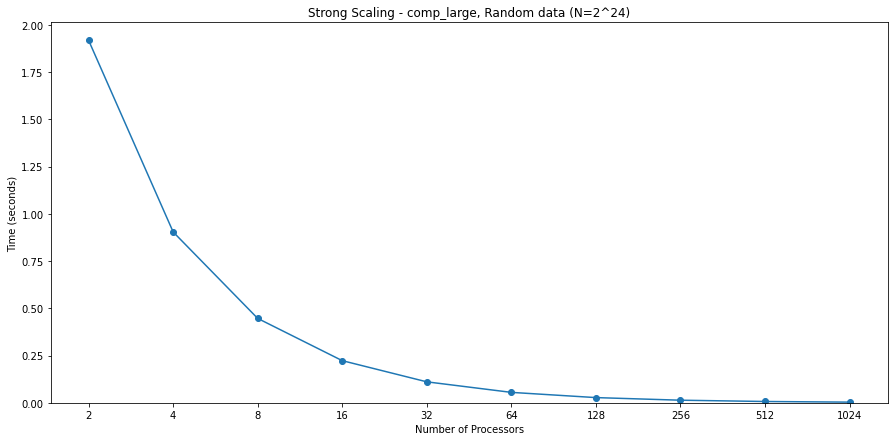

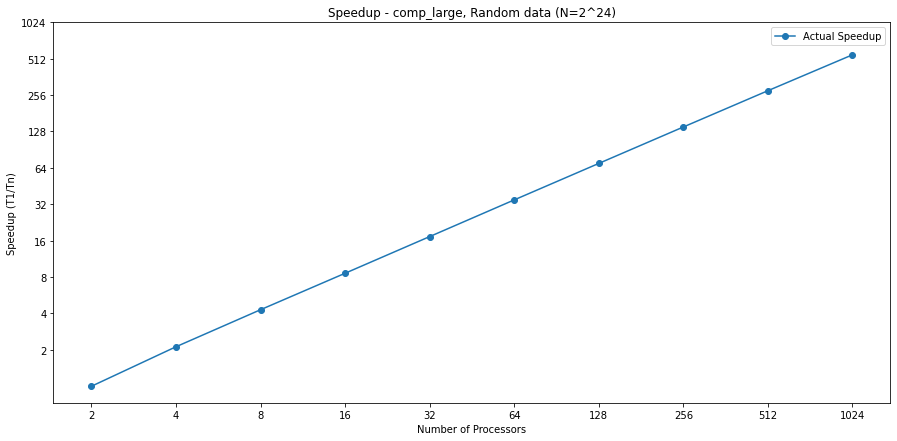

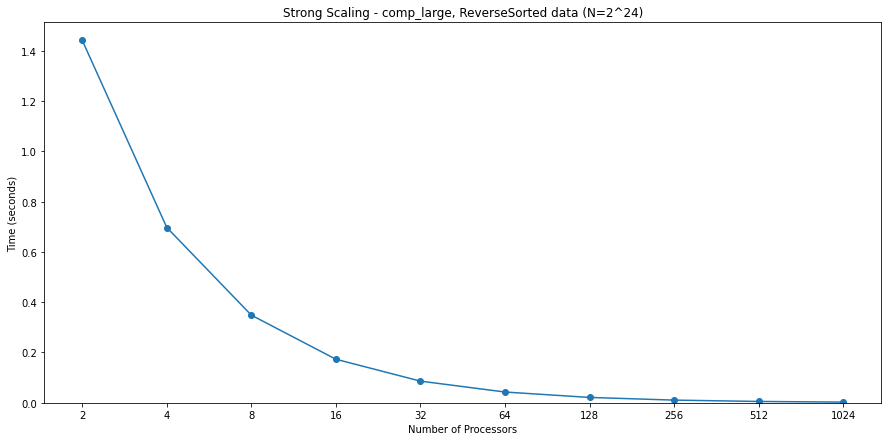

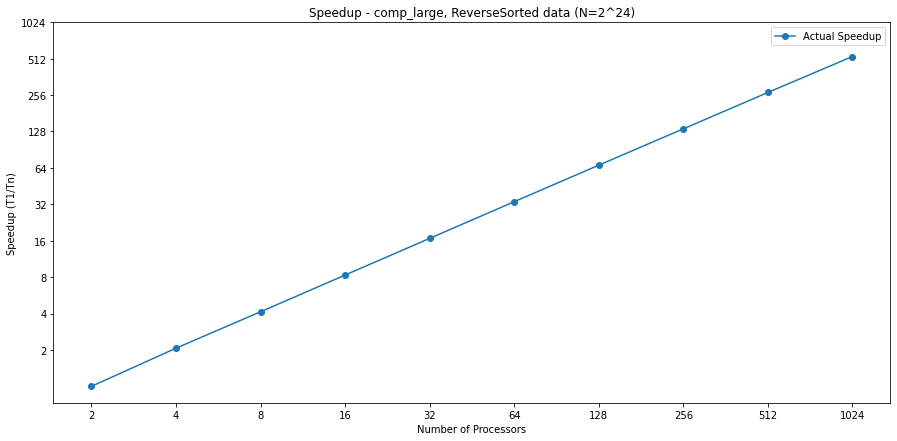

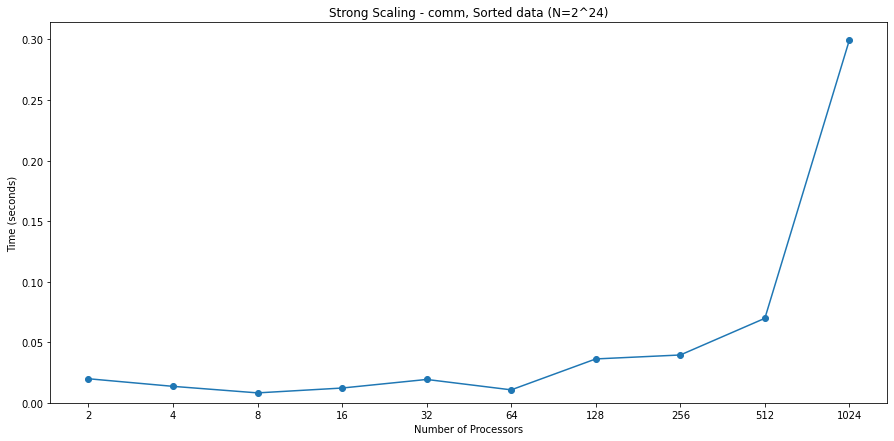

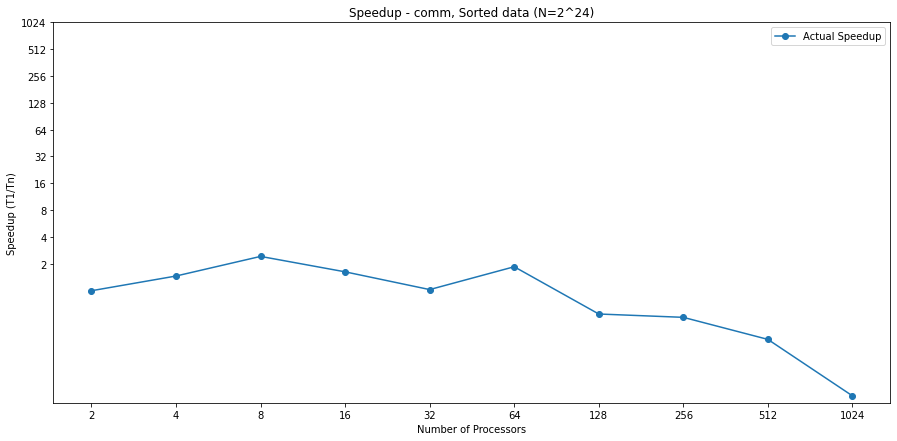

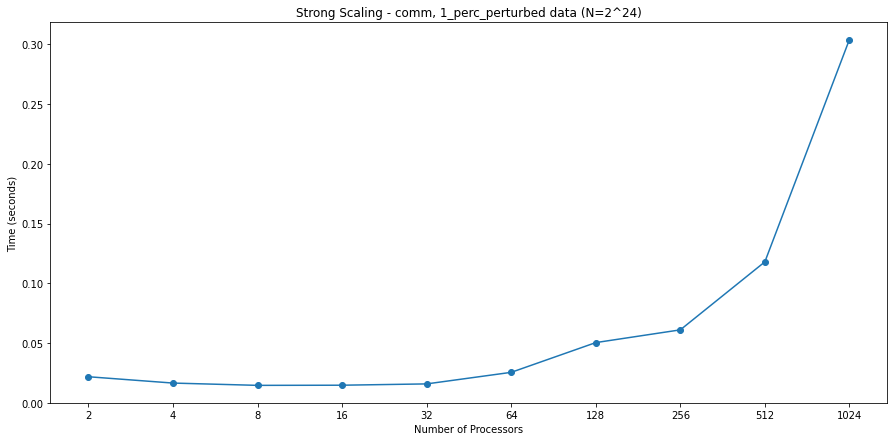

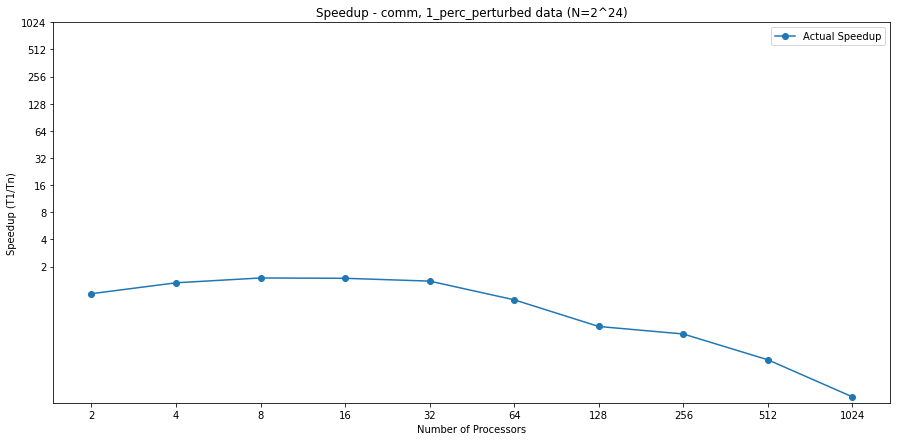

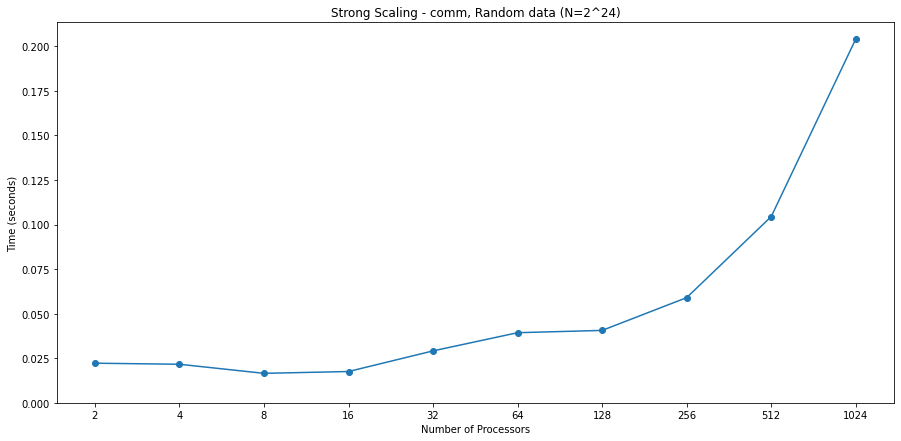

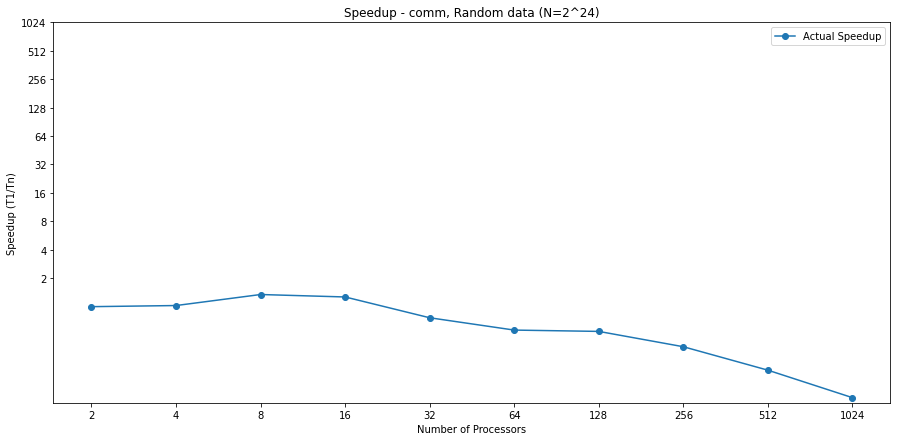

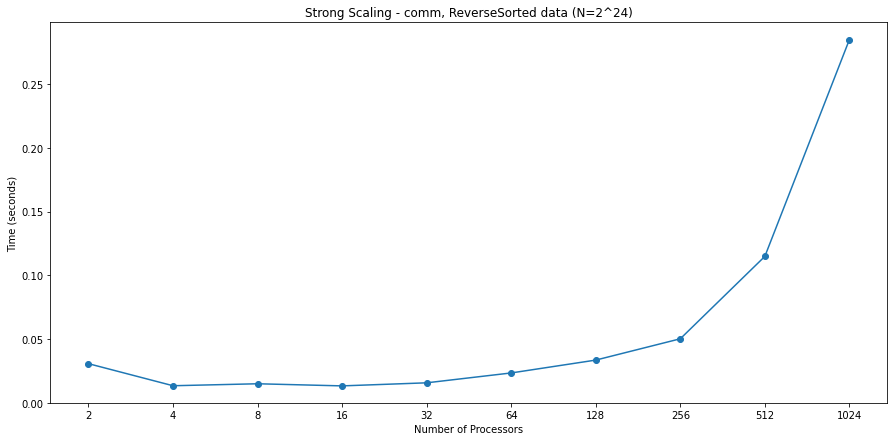

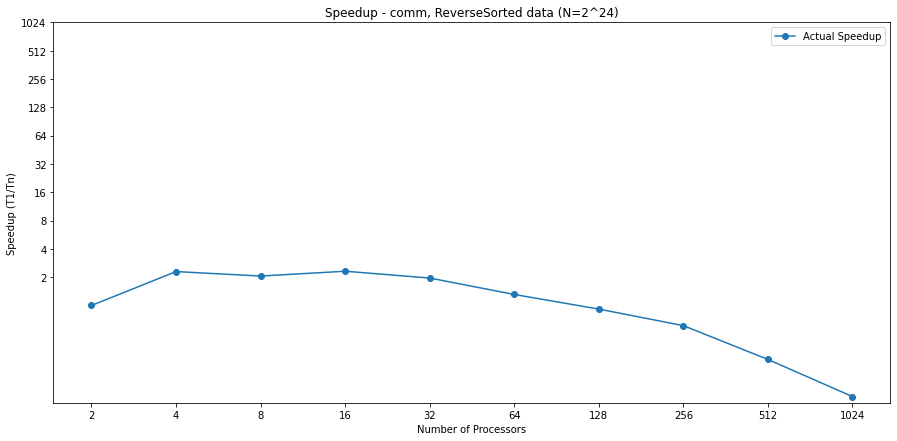

In [8]:
for cat in categories:
    for type in input_types:
        strong_df = plot_strong_scaling(df, cat, type)
        speedup_df = plot_speedup(df, cat, type)